In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)

# set the age structure
M=16  ## number of age classes
Ni = pyross.utils.getPopulation(country='UK', M=M)
min_age = 2.5; max_age = 77.5; age = np.linspace(min_age,max_age, M)
N = np.sum(Ni)

CH, CW, CS, CO = pyross.contactMatrix.UK()
def contactMatrix(t):
    return CH + CW + CS + CO

alpha = 0.66*np.exp(-age/50.5) 

Tf = 800
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M))
Ia0[2] += 10
S0[2] -= 10

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

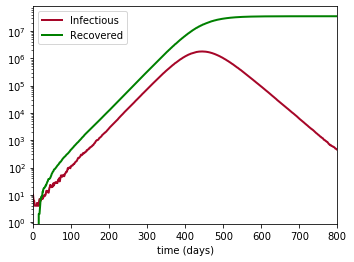

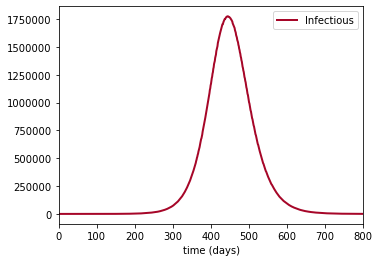

In [3]:
## Plot Results ##

Infectious = np.sum((sto_model.Is(data) + sto_model.Ia(data)), axis=1) 
R = np.sum(sto_model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2) 
plt.legend()
plt.show()

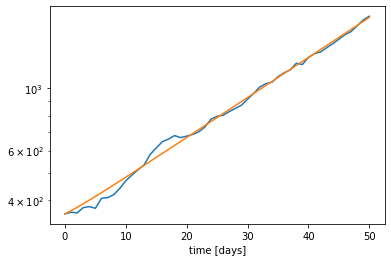

In [4]:
# load the data and rescale to intensive variables 
N_start = 150
Tf_inference = 50
Nf_inference = Tf_inference + 1

x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]

# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -M:], axis=1))
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1))
plt.xlabel("time [days]")
plt.show()

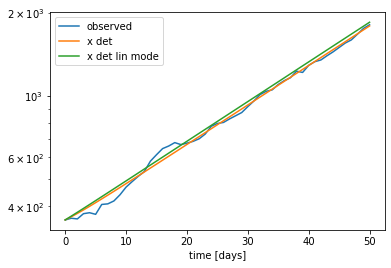

In [9]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1)

init_priors = {
    'lin_mode_coeff':{
        'fltr': np.repeat([False, True, True, False], M), # Use fastest lin modes to guess E, Ia 
        'mean': c, 
        'std': c, 
        'bounds': [c*0.1, c*10]
    }
}


x0_approx = estimator.get_mean_inits(init_priors, obs[0], fltr)

xm_approx = estimator.integrate(x0_approx, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -M:], axis=1), label='observed')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1), label='x det')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -M:], axis=1), label='x det lin mode')
plt.xlabel("time [days]")
plt.legend()
plt.show()

In [10]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

logp = estimator.minus_logp_red(parameters, x0_approx, obs, fltr, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

4004.1987176747716
0.3907129764556885


In [11]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.03, 
        'std': 0.03, 
        'bounds': (eps, 1)
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.02, 
        'bounds': (eps, 1)
    }, 
    'gIs':{
        'mean': 0.15, 
        'std': 0.02, 
        'bounds': (eps, 1)
    }, 
    'gE':{
        'mean': 0.11, 
        'std': 0.02, 
        'bounds': (eps, 0.2)
    }
}

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  

start_time = time.time()
params = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, 
                                            param_priors, init_priors, 
                                            tangent=True,
                                            enable_global=True, 
                                            cma_population=16,
                                            global_max_iter=100, global_atol=10, 
                                            local_max_iter=200,                  
                                            verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=3753766865, Tue Jun 30 14:23:18 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 4.664077712719146e+03 1.0e+00 9.49e-01  2e-02  5e+03 0:04.7
    2     32 4.060727618883805e+03 1.5e+00 9.35e-01  2e-02  5e+03 0:09.9
    3     48 4.235916820790437e+03 1.7e+00 8.68e-01  1e-02  4e+03 0:16.0
    4     64 4.018905477146118e+03 2.0e+00 7.40e-01  1e-02  3e+03 0:21.7
    5     80 4.223627939904148e+03 2.1e+00 7.02e-01  1e-02  3e+03 0:27.0
    6     96 4.032134378292089e+03 2.6e+00 6.80e-01  8e-03  3e+03 0:32.4
    8    128 4.038040770757887e+03 3.5e+00 7.13e-01  7e-03  3e+03 0:41.3
   10    160 4.033632679686208e+03 5.7e+00 6.08e-01  4e-03  2e+03 0:49.5
   13    208 4.008188397839006e+03 8.0e+00 4.17e-01  2e-03  1e+03 0:59.6
   16    256 4.002461704757081e+03 1.1e+01 3.48e-01  1e-03  7e+02 1:10.4
   19    304 3.998094166699205e+03 1.2e+01 1.88e-01  6e-04  3e+02 1:22.

In [12]:
##### print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix)
print(parameters, logp)

print('\nTrue initial conditions: ') 
print((x0).astype('int'))
print('R initial = ', (Ni - np.sum(x0.reshape((4, M)), axis=0)))

best_estimates = params['map_params_dict']
map_x0 = params['map_x0']

estimator.set_params(best_estimates)
logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix)

print('\nBest estimates')
print(best_estimates, logp)


print('\nInferred initial conditons: ') 
print((map_x0).astype('int'))
print('R initial = ', (Ni - np.sum(map_x0.reshape((4, M)), axis=0)).astype('int'))

True parameters
{'alpha': array([0.62812229, 0.56891156, 0.51528239, 0.46670865, 0.42271377,
       0.38286612, 0.34677477, 0.31408561, 0.28447793, 0.25766126,
       0.2333725 , 0.21137334, 0.19144797, 0.17340089, 0.15705503,
       0.14225004]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 1} 3978.4687189086894

True initial conditions: 
[3950913 4114056 3884361 3683943 4119934 4510016 4683327 4519602 4270505
 4353556 4674666 4463179 3799378 3406906 3329386 2343913      34      49
      62     132      59      98      81      74      54      87      65
      63      23      17      27      11      15      19      11      41
      26      14      11      18      10       8       4       7       3
       2       3       1       5      13      23      44      31      21
      33      35      28      33      24      24      18      11      10
       4]
R initial =  [ 79. 100. 159. 374. 219. 196. 184. 204. 188. 210. 159. 174.  63.  54.
  70.  32.

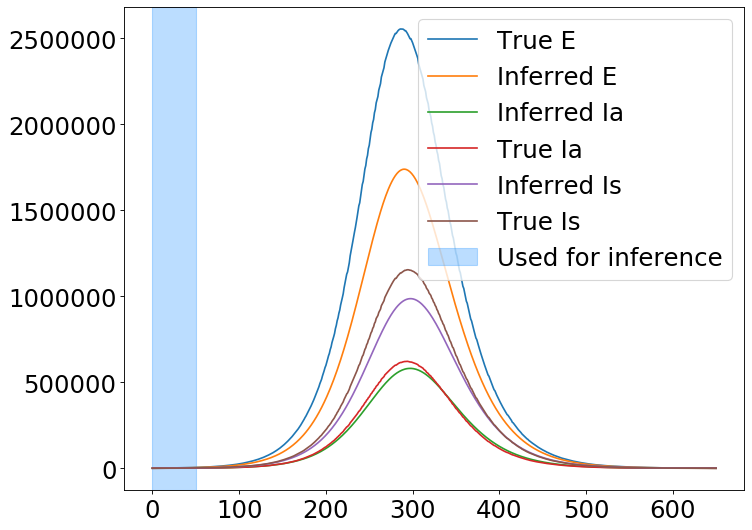

In [14]:
# plot the guessed trajectory and the true trajectory
Tf = 800
Nf = Tf+1

estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf-N_start, Nf-N_start)
x = data['X'][N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x[:,M:2*M], axis=1), label='True E')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred E')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()